In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

> ## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.base import BaseEstimator,MetaEstimatorMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor


In [4]:
#for some statistics
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


In [5]:
sns.set_style('whitegrid')
pd.options.display.max_rows = 100


## Data

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train_Id = train['Id']
test_Id = test['Id']

In [8]:
y_train = train['SalePrice']

In [9]:
all_data = pd.concat([train.drop(['SalePrice'],axis=1),test],axis=0)

In [10]:
train.shape,all_data.shape

((1460, 81), (2919, 80))

## EDA

In [10]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

skewness: 1.883
kurotsis: 6.536


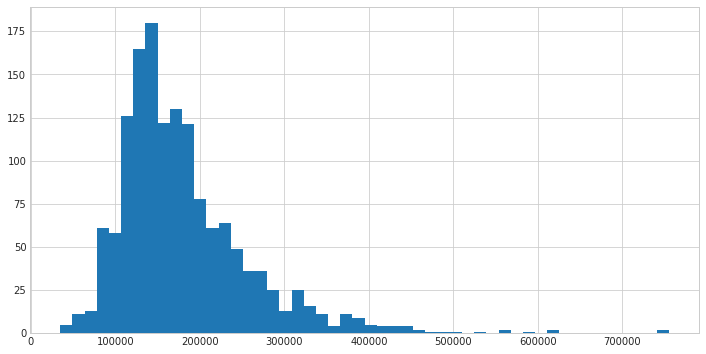

In [11]:
plt.figure(figsize=(12,6))
train['SalePrice'].hist(bins=50)
print('skewness: {:.3f}'.format(train['SalePrice'].skew()))
print('kurotsis: {:.3f}'.format(train['SalePrice'].kurt()))

#### There are some outliers we can observe form kurtosis and skewness in the target data. 
#### Normalize the data using the log transformation. and verify the changes.

#### .


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


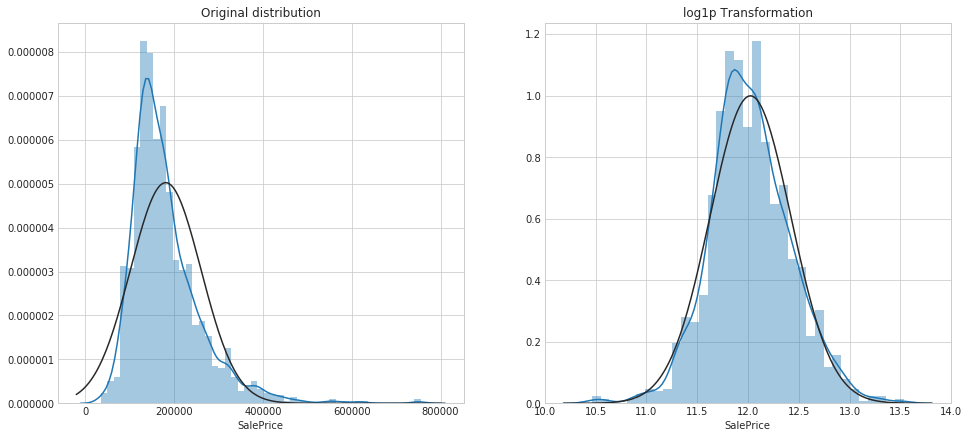

In [13]:

# target value dist,comapred with normal dist of target

# transforming target value to log(x), ML algs do well with normally distributed data

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(16,7))


sns.distplot(train['SalePrice'],fit=norm,ax=ax[0])
ax[0].set_title('Original distribution')


sns.distplot(np.log1p(train['SalePrice']),fit=norm,ax=ax[1])
ax[1].set_title('log1p Transformation')

plt.show()

## Relevance of features-target

### % of missing values
### datatypes
### type of values
### correlations


In [14]:
summ = pd.DataFrame({'dtype':train.dtypes,'unique':train.nunique(),
              'values':{ str(i):train[i].value_counts().index.tolist() for i in train.columns.tolist()},
             'null':train.isnull().sum(),
             'corr':train.corr()['SalePrice']}).sort_values(by='null',ascending=False)

In [15]:
summ

,dtype,unique,values,null,corr
PoolQC,object,3,"[Gd, Fa, Ex]",1453,NaN
MiscFeature,object,4,"[Shed, Othr, Gar2, TenC]",1406,NaN
Alley,object,2,"[Grvl, Pave]",1369,NaN
Fence,object,4,"[MnPrv, GdPrv, GdWo, MnWw]",1179,NaN
FireplaceQu,object,5,"[Gd, TA, Fa, Ex, Po]",690,NaN
LotFrontage,float64,110,"[60.0, 70.0, 80.0, 50.0, 75.0, 65.0, 85.0, 78....",259,0.351799
GarageFinish,object,3,"[Unf, RFn, Fin]",81,NaN
GarageQual,object,5,"[TA, Fa, Gd, Po, Ex]",81,NaN
GarageType,object,6,"[Attchd, Detchd, BuiltIn, Basment, CarPort, 2T...",81,NaN
GarageYrBlt,float64,97,"[2005.0, 2006.0, 2004.0, 2003.0, 2007.0, 1977....",81,0.486362


In [16]:
## working with the missing values

summ[summ['null']>0]

,dtype,unique,values,null,corr
PoolQC,object,3,"[Gd, Fa, Ex]",1453,NaN
MiscFeature,object,4,"[Shed, Othr, Gar2, TenC]",1406,NaN
Alley,object,2,"[Grvl, Pave]",1369,NaN
Fence,object,4,"[MnPrv, GdPrv, GdWo, MnWw]",1179,NaN
FireplaceQu,object,5,"[Gd, TA, Fa, Ex, Po]",690,NaN
LotFrontage,float64,110,"[60.0, 70.0, 80.0, 50.0, 75.0, 65.0, 85.0, 78....",259,0.351799
GarageFinish,object,3,"[Unf, RFn, Fin]",81,NaN
GarageQual,object,5,"[TA, Fa, Gd, Po, Ex]",81,NaN
GarageType,object,6,"[Attchd, Detchd, BuiltIn, Basment, CarPort, 2T...",81,NaN
GarageYrBlt,float64,97,"[2005.0, 2006.0, 2004.0, 2003.0, 2007.0, 1977....",81,0.486362


In [17]:
# Analizing Garage features

train.loc[train['GarageQual'].isnull(),['Id','GarageFinish','GarageQual','GarageType','GarageYrBlt','GarageCond']].head()

,Id,GarageFinish,GarageQual,GarageType,GarageYrBlt,GarageCond
39,40,NaN,NaN,NaN,NaN,NaN
48,49,NaN,NaN,NaN,NaN,NaN
78,79,NaN,NaN,NaN,NaN,NaN
88,89,NaN,NaN,NaN,NaN,NaN
89,90,NaN,NaN,NaN,NaN,NaN


In [18]:
# Analizing Lot features
lotfrontage = train[['LotFrontage','LotArea','LotShape','LotConfig']]

train.loc[train['LotFrontage'].isnull(),['LotFrontage','LotArea','LotShape','LotConfig']].groupby('LotConfig')['LotConfig'].value_counts()

LotConfig  LotConfig
Corner     Corner        62
CulDSac    CulDSac       49
FR2        FR2           14
Inside     Inside       134
Name: LotConfig, dtype: int64

In [19]:
lotfrontage[lotfrontage['LotFrontage'].isnull()].head()

,LotFrontage,LotArea,LotShape,LotConfig
7,NaN,10382,IR1,Corner
12,NaN,12968,IR2,Inside
14,NaN,10920,IR1,Corner
16,NaN,11241,IR1,CulDSac
24,NaN,8246,IR1,Inside


In [20]:
train['SalePrice'].corr(train['LotFrontage'])

0.3517990965706778

In [21]:
summ

,dtype,unique,values,null,corr
PoolQC,object,3,"[Gd, Fa, Ex]",1453,NaN
MiscFeature,object,4,"[Shed, Othr, Gar2, TenC]",1406,NaN
Alley,object,2,"[Grvl, Pave]",1369,NaN
Fence,object,4,"[MnPrv, GdPrv, GdWo, MnWw]",1179,NaN
FireplaceQu,object,5,"[Gd, TA, Fa, Ex, Po]",690,NaN
LotFrontage,float64,110,"[60.0, 70.0, 80.0, 50.0, 75.0, 65.0, 85.0, 78....",259,0.351799
GarageFinish,object,3,"[Unf, RFn, Fin]",81,NaN
GarageQual,object,5,"[TA, Fa, Gd, Po, Ex]",81,NaN
GarageType,object,6,"[Attchd, Detchd, BuiltIn, Basment, CarPort, 2T...",81,NaN
GarageYrBlt,float64,97,"[2005.0, 2006.0, 2004.0, 2003.0, 2007.0, 1977....",81,0.486362


  Observing above missing value features, we can coclude that those features are not avalabel in the property.<br>
  
   'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GarageCond' <br>
    BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond, BsmtFinType1 <br>
    MasVnrType, MasVnrArea   <br>
    

 * LotFrontage: Linear feet of street-connected to property   In this case Lot area is there but not accessible to the road directly. and it is equally correlated with SalePrice compared to the lot area.
 
* All catagorical features in this dataset are ordinal in nature, all these features are transformed to numarical order and missing values are imputed with zero

### automatic outlier detecting

In [22]:
def detect_outliers(x, y, top=5, plot=True):
    
    lof = LocalOutlierFactor(n_neighbors=40, contamination=0.1)
    
    x_ =np.array(x).reshape(-1,1)
    
    preds = lof.fit_predict(x_)
    
    lof_scr = lof.negative_outlier_factor_
    
    out_idx = pd.Series(lof_scr).sort_values()[:top].index
    
    if plot:
        f, ax = plt.subplots(figsize=(9, 6))
        plt.scatter(x=x, y=y, c=np.exp(lof_scr), cmap='RdBu')
    return out_idx

Int64Index([1298, 523, 1182, 691, 533], dtype='int64')

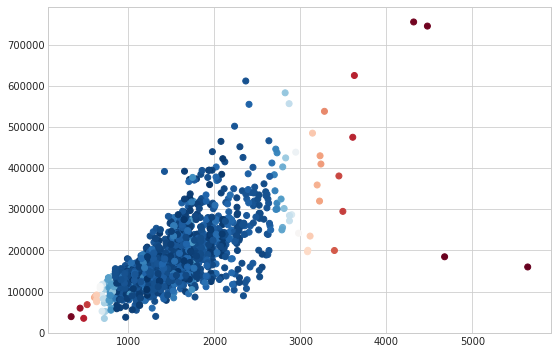

In [23]:
outs = detect_outliers(train['GrLivArea'], train['SalePrice'],top=5) #got 1298,523
outs

Int64Index([185, 170, 635, 1009, 88], dtype='int64')

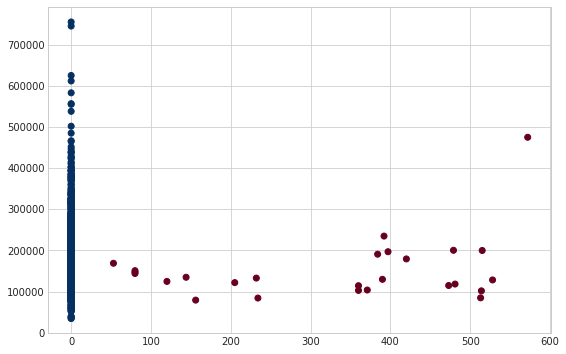

In [24]:
outs = detect_outliers(train['LowQualFinSF'], train['SalePrice'],top=5)#got 88
outs

In [25]:
outliers = [30, 88, 462, 523, 632, 1298, 1324]

In [26]:
from collections import Counter

all_outliers = []

numeric_features = train.dtypes[train.dtypes != 'object'].index

for feature in numeric_features:
    
    try:
        outs = detect_outliers(train[feature],train['SalePrice'],top=5,plot=False)
    except:
        continue
    all_outliers.extend(outs)


In [27]:
for i in outliers:
    if i in all_outliers:
        print(i)

88
523
1298


In [28]:
train = train.drop(train.index[outliers])

In [29]:
train.shape

(1453, 81)

In [30]:
#y = train.SalePrice.rest_index(drop=True)

train_features = train.drop(['SalePrice'],axis=1)
test_features = test
features = pd.concat([train_features,test_features]).reset_index(drop=True)


features.drop(['Id'],axis=1,inplace=True)
print(features.shape)

(2912, 79)


In [60]:
features_labels = train['SalePrice']

In [62]:
features_labels.shape

(1453,)

In [31]:
#2.2 numeric_features and 
numeric_features = features.dtypes[features.dtypes != 'object'].index
numeric_features
len(numeric_features)
category_features = features.dtypes[features.dtypes == 'object'].index
category_features
len(category_features)

43

In [32]:
#category_features,numeric_features

In [33]:
# 2.3 special features with NA ----> NO such feature

spacial_features=[ 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence']

len(spacial_features)

12

In [34]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [35]:
# Data transformation 

In [36]:
features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [37]:
# correlation of the numarical fearures
features_corr = features.corr()

In [47]:
miss_att = ['Id']
replace_val = 0


In [39]:

class DropMissingValAtt(BaseEstimator,MetaEstimatorMixin):
    def __init__(self,miss_att):
        self.miss_att = miss_att
    def fit(self,X):
        return self
    def transform(self,X):
        X.drop(miss_att,axis=1,inplace=True)
        return X


class EncodingCatOrdFeat(BaseEstimator,MetaEstimatorMixin):
    def __init__ (self,map_dict):
        self.map_dict = map_dict
    def fit(self,X):
        return self
    def transform(self,X):
        for i in map_dict.index:
            X[i] = X[i].map(map_dict[i])
        return X
    
class NullValReplace(BaseEstimator,MetaEstimatorMixin):
    def __init__ (self,replace_val):
        self.replace_val = replace_val
    def fit(self,X):
        return self
    def transform(self,X):
        X.fillna(replace_val, inplace=True)
        return X
        

In [40]:
# Creating the Series of dicts for maping catagorical variables. Example:  Alley  {'Grvl': 1, 'Pave': 2}

def data_summary(data,miss_att):
    try:
        df = data.drop(miss_att,axis=1)
    except:
        df = data.copy()
    
    summ = pd.DataFrame({'dtype':df.dtypes,'unique':df.nunique(),
              'values':{ str(i):df[i].value_counts().index.tolist() for i in df.columns.tolist()},
             'null':df.isnull().sum()})
    summ['value_dict'] = summ.loc[summ['dtype'] == 'object']['values'].apply(lambda l : { l[i]:l.index(l[i]) +1   for i in range(len(l))})
    
    map_dict = summ.loc[summ['dtype'] == 'object','value_dict']
    
    return summ,map_dict
    
    

In [41]:
summary,map_dict= data_summary(train_features,miss_att)

In [42]:
map_dict

Alley                                       {'Grvl': 1, 'Pave': 2}
BldgType         {'1Fam': 1, 'TwnhsE': 2, 'Duplex': 3, 'Twnhs':...
BsmtCond                      {'TA': 1, 'Gd': 2, 'Fa': 3, 'Po': 4}
BsmtExposure                  {'No': 1, 'Av': 2, 'Gd': 3, 'Mn': 4}
BsmtFinType1     {'Unf': 1, 'GLQ': 2, 'ALQ': 3, 'BLQ': 4, 'Rec'...
BsmtFinType2     {'Unf': 1, 'Rec': 2, 'LwQ': 3, 'BLQ': 4, 'ALQ'...
BsmtQual                      {'TA': 1, 'Gd': 2, 'Ex': 3, 'Fa': 4}
CentralAir                                        {'Y': 1, 'N': 2}
Condition1       {'Norm': 1, 'Feedr': 2, 'Artery': 3, 'RRAn': 4...
Condition2       {'Norm': 1, 'Feedr': 2, 'RRNn': 3, 'Artery': 4...
Electrical       {'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': ...
ExterCond            {'TA': 1, 'Gd': 2, 'Fa': 3, 'Ex': 4, 'Po': 5}
ExterQual                     {'TA': 1, 'Gd': 2, 'Ex': 3, 'Fa': 4}
Exterior1st      {'VinylSd': 1, 'HdBoard': 2, 'MetalSd': 3, 'Wd...
Exterior2nd      {'VinylSd': 1, 'MetalSd': 2, 'HdBoard': 3, 'W

In [43]:
pipeline = Pipeline([
    ('drop_miss_att',DropMissingValAtt(miss_att) ),
    ('encoding_cat_ord',EncodingCatOrdFeat(map_dict)),
    ('null_value_replace',NullValReplace(replace_val))
    
])

In [44]:
train_features = pipeline.transform(train_features)

In [46]:
features = pipeline.transform(features)

In [49]:
features.shape

(2912, 79)

In [51]:
features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [52]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,60,1.0,65.0,8450,1,0.0,1,1,1.0,1,...,0,2,2008,1.0,1,4006,2566.0,2416.0,3.5,61
1,20,1.0,80.0,9600,1,0.0,1,1,1.0,4,...,0,5,2007,1.0,1,3952,2524.0,2240.0,2.5,298
2,60,1.0,68.0,11250,1,0.0,2,1,1.0,1,...,0,9,2008,1.0,1,4003,2706.0,2272.0,3.5,42
3,70,1.0,60.0,9550,1,0.0,2,1,1.0,2,...,0,2,2006,1.0,3,3885,2473.0,1933.0,2.0,307
4,60,1.0,84.0,14260,1,0.0,2,1,1.0,4,...,0,12,2008,1.0,1,4000,3343.0,2853.0,3.5,276


In [53]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [54]:
features[['haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace']].head()

,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,0,1,1,1,0
1,0,0,1,1,1
2,0,1,1,1,1
3,0,1,1,1,1
4,0,1,1,1,1


In [56]:
# total area is more correlated with price.(.78)

features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

In [58]:
# sns.pairplot(df)

In [57]:
features_corr = features.corr()

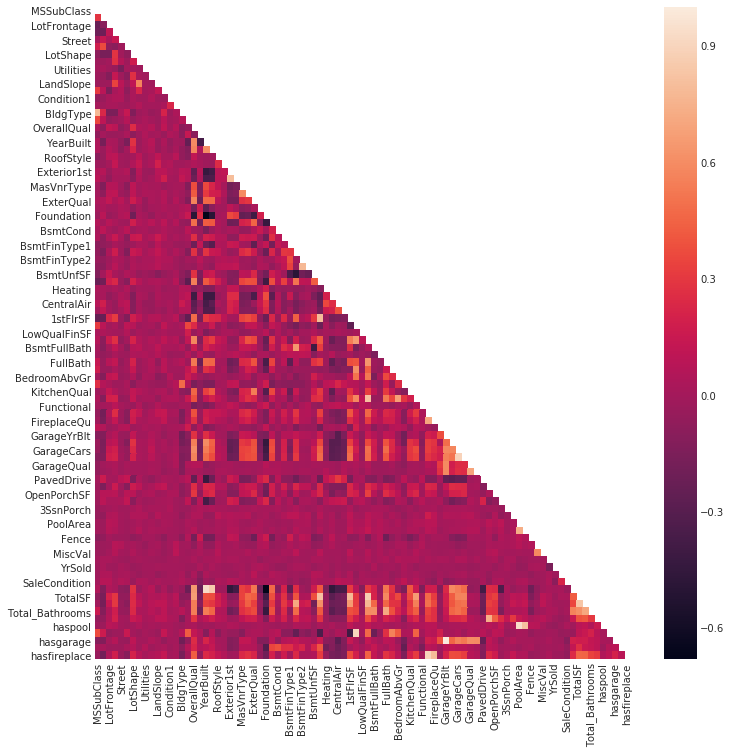

In [59]:
plt.figure(figsize=(12,12))

# Generate a mask for the upper triangle
mask = np.zeros_like(features_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(features_corr,mask=mask)

plt.show()

In [111]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)


#(Root Mean Squared Logarithmic Error ，RMSLE)
def rmsle(y, y_pred):
    return np.sqrt(mse(y, y_pred))


def cv_rmse(model, X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [76]:
#Validation function
n_folds = 5

def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#(Root Mean Squared Logarithmic Error ，RMSLE)

def rmsle(model,X,y):
    
    model.fit(X, y)

    y_pred = model.predict(X)
    error = np.sqrt(mean_squared_error(y, y_pred))
    
    return error

In [68]:
train_features.drop('Id',axis=1,inplace=True)

In [96]:
train_features['MSZoning'].isnull().sum()

0

In [106]:
skewness = []

In [113]:
skew = train_features.skew().sort_values(ascending=True)

skewness = skew[skew > 0.75]


In [114]:

skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train_features[feat] = boxcox1p(train_features[feat], lam)

In [115]:
train_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5.684507,0.730463,65.0,19.212182,0.730463,0.0,0.730463,0.730463,0.730463,0.730463,...,0.0,0.0,0.0,0.0,0.0,0.0,2,2008,0.730463,0.730463
1,3.858807,0.730463,80.0,19.712205,0.730463,0.0,0.730463,0.730463,0.730463,1.820334,...,0.0,0.0,0.0,0.0,0.0,0.0,5,2007,0.730463,0.730463
2,5.684507,0.730463,68.0,20.347241,0.730463,0.0,1.194318,0.730463,0.730463,0.730463,...,0.0,0.0,0.0,0.0,0.0,0.0,9,2008,0.730463,0.730463
3,5.968981,0.730463,60.0,19.691553,0.730463,0.0,1.194318,0.730463,0.730463,1.194318,...,0.0,0.0,0.0,0.0,0.0,0.0,2,2006,0.730463,1.540963
4,5.684507,0.730463,84.0,21.325160,0.730463,0.0,1.194318,0.730463,0.730463,1.820334,...,0.0,0.0,0.0,0.0,0.0,0.0,12,2008,0.730463,0.730463


# Model

In [70]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
#import xgboost as xgb
#import lightgbm as lgb


In [71]:

gbrt = GradientBoostingRegressor(max_depth=12, n_estimators=270)


In [116]:
## Train error
rmsle(gbrt,train_features,features_labels)

0.03200946710845823

In [117]:
# cross validation
rmsle_cv(gbrt,train_features,features_labels)

array([34645.17181044, 31632.72607676, 39291.68759606, 28825.84822808,
       35718.77900932])

In [87]:
train_add_features = features.iloc[train.index]

In [88]:
train_add_features.shape

(1453, 89)

In [89]:

# cross validation
rmsle_cv(gbrt,train_add_features,features_labels)

array([81666.1965638 , 86688.4437185 , 98357.18991108, 81581.79700888,
       88183.33276913])

In [90]:
rmsle(gbrt,train_add_features,features_labels)

11.93108544522651

In [ ]:
adbost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=12),
                          n_estimators=300, random_state=42)



In [ ]:
gbrt_error,#np.sqrt(adbost_error)

In [ ]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)
    rmse= np.sqrt(-cross_val_score(model, df, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
rmsle_cv(gbrt)

In [ ]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)
kf.get_n_splits(train.values)

In [ ]:
# 12,270
errors

In [ ]:
param_grid = [
  {'max_depth': np.arange(4,20), 'n_estimators': np.arange(250,3000,200)}
 ]

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
summ,di = data_summary(df_test,miss_att)

In [ ]:
df_test = pipeline.transform(test)

In [ ]:
y_test_pred = gbrt.predict(df_test)

In [ ]:
sub.columns

In [ ]:
submission = pd.DataFrame({'Id':sub['Id'],'SalePrice':y_test_pred})

In [ ]:
submission.to_csv('submission2.csv',index=False)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbrt, df, train_y, cv=10, scoring='neg_mean_squared_error')



In [ ]:
scores

In [ ]:
scores.mean()

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.SCORERS.keys()

In [ ]:
summ_dy = pd.DataFrame({'dtype':train_dy.dtypes,'unique':train_dy.nunique(),
              'values':{ str(i):train_dy[i].value_counts().index.tolist() for i in train_dy.columns.tolist()},
             'null':train_dy.isnull().sum(),
             'corr':train_dy.corr()['SalePrice']}).sort_values(by='corr',ascending=False)

In [ ]:
summ_dy

In [ ]:
train_df = train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Id'],axis=1)

summ = pd.DataFrame({'dtype':train_df.dtypes,'unique':train_df.nunique(),
              'values':{ str(i):train_df[i].value_counts().index.tolist() for i in train_df.columns.tolist()},
             'null':train_df.isnull().sum(),
             'corr':train_df.corr()['SalePrice']}).sort_values(by='null',ascending=False)

summ['value_dict'] = summ.loc[summ['dtype'] == 'object']['values'].apply(lambda l : { l[i]:l.index(l[i]) +1   for i in range(len(l))})

dicts = summ.loc[summ['dtype'] == 'object','value_dict']